# ***LSTM ile Hava Kirliliği Tahmini (Air Pollution Forecasting with LSTM)***

# Problem Tanımı
- Hava kirliliği, dünya çapında insan sağlığını tehdit eden en önemli çevresel sorunlardan biridir. Bu projede hava kirliliği ölçümü olarak pollution partikül konsantrasyonu ele alınmıştır. pollution, 2.5 mikrometre çapından küçük partikülleri temsil eder ve solunum yollarına derinlemesine nüfuz ederek ciddi sağlık sorunlarına neden olabilir.

# Amaç:
- Bu çalışmanın amacı, geçmiş saatlere ait hava koşulları ve pollution değerlerini kullanarak LSTM (Long Short-Term Memory) yapay sinir ağı modeli ile bir sonraki saatteki PM2.5 değerini tahmin etmektir. Zaman serisi verisi olarak düzenlenmiş bu problemin çözümü, hava kirliliğinin öngörülmesi ve gerekli önlemlerin zamanında alınabilmesi açısından kritik öneme sahiptir.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [27]:
# CSV dosyasını okuma
file_path = '/content/LSTM-Multivariate_pollution.csv'
df = pd.read_csv(file_path)

In [28]:
# İlk 5 satırı görüntüleme
print("Verinin İlk 5 Satırı:")
print(df.head())

Verinin İlk 5 Satırı:
                  date  pollution  dew  temp   press wnd_dir  wnd_spd  snow  \
0  2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0   
1  2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0   
2  2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0   
3  2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1   
4  2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2   

   rain  
0     0  
1     0  
2     0  
3     0  
4     0  


In [29]:
# Veri boyutunu kontrol etme
print("\nVeri Setinin Boyutu:")
print(df.shape)


Veri Setinin Boyutu:
(43800, 9)


In [30]:
# Sütun isimlerini listeleme
print("\nSütun İsimleri:")
print(df.columns)


Sütun İsimleri:
Index(['date', 'pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd',
       'snow', 'rain'],
      dtype='object')


In [31]:
# Veri türlerini kontrol etme
print("\nSütunların Veri Türleri:")
print(df.dtypes)


Sütunların Veri Türleri:
date          object
pollution    float64
dew            int64
temp         float64
press        float64
wnd_dir       object
wnd_spd      float64
snow           int64
rain           int64
dtype: object


In [32]:
# Eksik değerleri kontrol etme
print("\nEksik Değerlerin Sayısı:")
print(df.isnull().sum())


Eksik Değerlerin Sayısı:
date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64


- Date: Zaman bilgisi (saatlik).
- Pollution: PM2.5 hava kirliliği ölçümü (hedef değişken).
- Dew: Çiy noktası.
- Temp: Sıcaklık.
- Press: Basınç.
- Wnd_dir: Rüzgar yönü (kategorik).
- Wnd_spd: Rüzgar hızı.
- Snow: Kar yağış süresi (saat).
- Rain: Yağmur yağış süresi (saat).


In [33]:
# Numerik sütunların istatistiksel özeti
print("\nTemel İstatistiksel Özet:")
print(df.describe())


Temel İstatistiksel Özet:
          pollution           dew          temp         press       wnd_spd  \
count  43800.000000  43800.000000  43800.000000  43800.000000  43800.000000   
mean      94.013516      1.828516     12.459041   1016.447306     23.894307   
std       92.252276     14.429326     12.193384     10.271411     50.022729   
min        0.000000    -40.000000    -19.000000    991.000000      0.450000   
25%       24.000000    -10.000000      2.000000   1008.000000      1.790000   
50%       68.000000      2.000000     14.000000   1016.000000      5.370000   
75%      132.250000     15.000000     23.000000   1025.000000     21.910000   
max      994.000000     28.000000     42.000000   1046.000000    585.600000   

               snow          rain  
count  43800.000000  43800.000000  
mean       0.052763      0.195023  
std        0.760582      1.416247  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%      

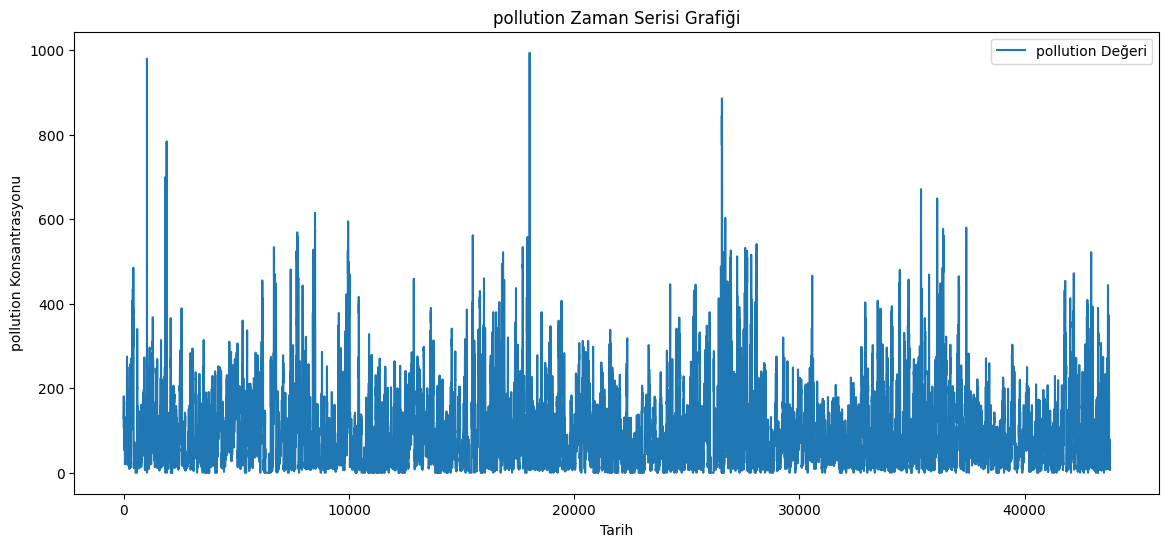

In [34]:
# pollution değerinin zaman içindeki değişimi
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pollution'], label='pollution Değeri')
plt.xlabel('Tarih')
plt.ylabel('pollution Konsantrasyonu')
plt.title('pollution Zaman Serisi Grafiği')
plt.legend()
plt.show()

In [35]:
df["wnd_dir"].value_counts()

,count
wnd_dir,
SE,15290
NW,14130
cv,9384
NE,4996


In [36]:
# Numerik sütunların istatistiksel özeti
print("\nTemel İstatistiksel Özet:")
print(df.describe())

# 'date' sütununu datetime formatına dönüştürme
df['date'] = pd.to_datetime(df['date'])

# 'date' sütununu indeks olarak ayarlama
df.set_index('date', inplace=True)


Temel İstatistiksel Özet:
          pollution           dew          temp         press       wnd_spd  \
count  43800.000000  43800.000000  43800.000000  43800.000000  43800.000000   
mean      94.013516      1.828516     12.459041   1016.447306     23.894307   
std       92.252276     14.429326     12.193384     10.271411     50.022729   
min        0.000000    -40.000000    -19.000000    991.000000      0.450000   
25%       24.000000    -10.000000      2.000000   1008.000000      1.790000   
50%       68.000000      2.000000     14.000000   1016.000000      5.370000   
75%      132.250000     15.000000     23.000000   1025.000000     21.910000   
max      994.000000     28.000000     42.000000   1046.000000    585.600000   

               snow          rain  
count  43800.000000  43800.000000  
mean       0.052763      0.195023  
std        0.760582      1.416247  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%      

In [37]:
# Veri setinin başını kontrol etme
print("\nİndeks Olarak Ayarlanmış Veri Seti:")
print(df.head())


İndeks Olarak Ayarlanmış Veri Seti:
                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [40]:
# Kategorik değişkeni sayısallaştırma
label_encoder = LabelEncoder()
df['wnd_dir'] = label_encoder.fit_transform(df['wnd_dir'])

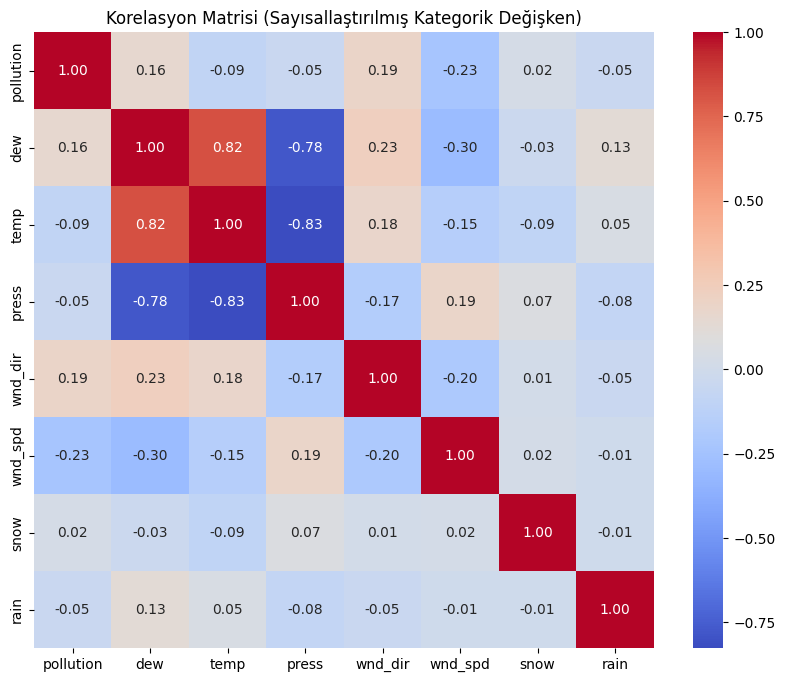

In [42]:
# Korelasyon matrisi hesaplama
correlation_matrix = df.corr()

# Korelasyon matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelasyon Matrisi (Sayısallaştırılmış Kategorik Değişken)")
plt.show()

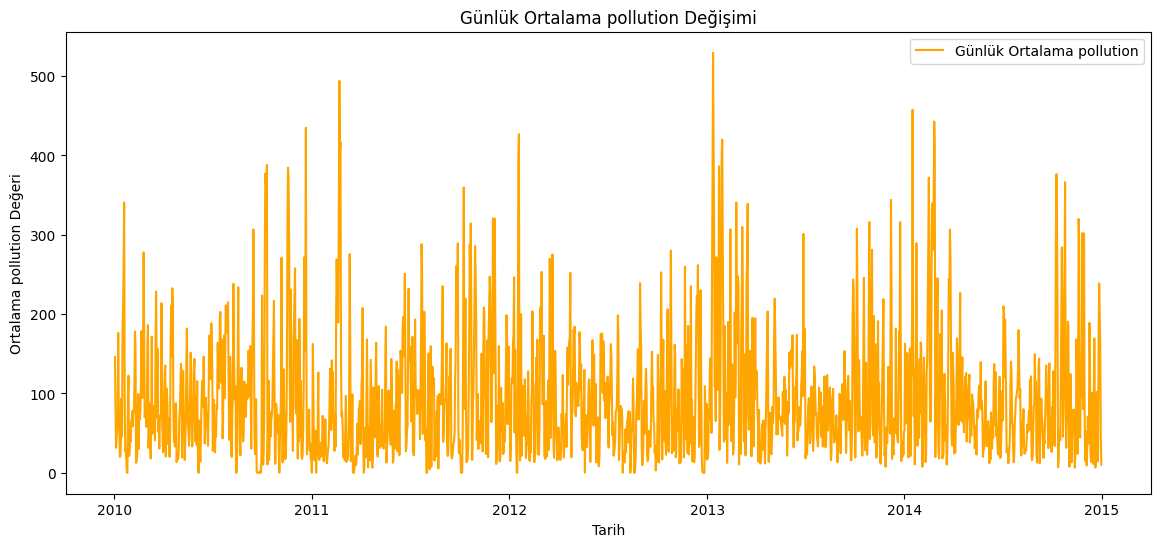

In [43]:
# Günlük ortalama pollution hesaplama
daily_avg = df['pollution'].resample('D').mean()

# Günlük ortalama pollution grafiği
plt.figure(figsize=(14, 6))
plt.plot(daily_avg.index, daily_avg, color='orange', label='Günlük Ortalama pollution')
plt.xlabel('Tarih')
plt.ylabel('Ortalama pollution Değeri')
plt.title('Günlük Ortalama pollution Değişimi')
plt.legend()
plt.show()

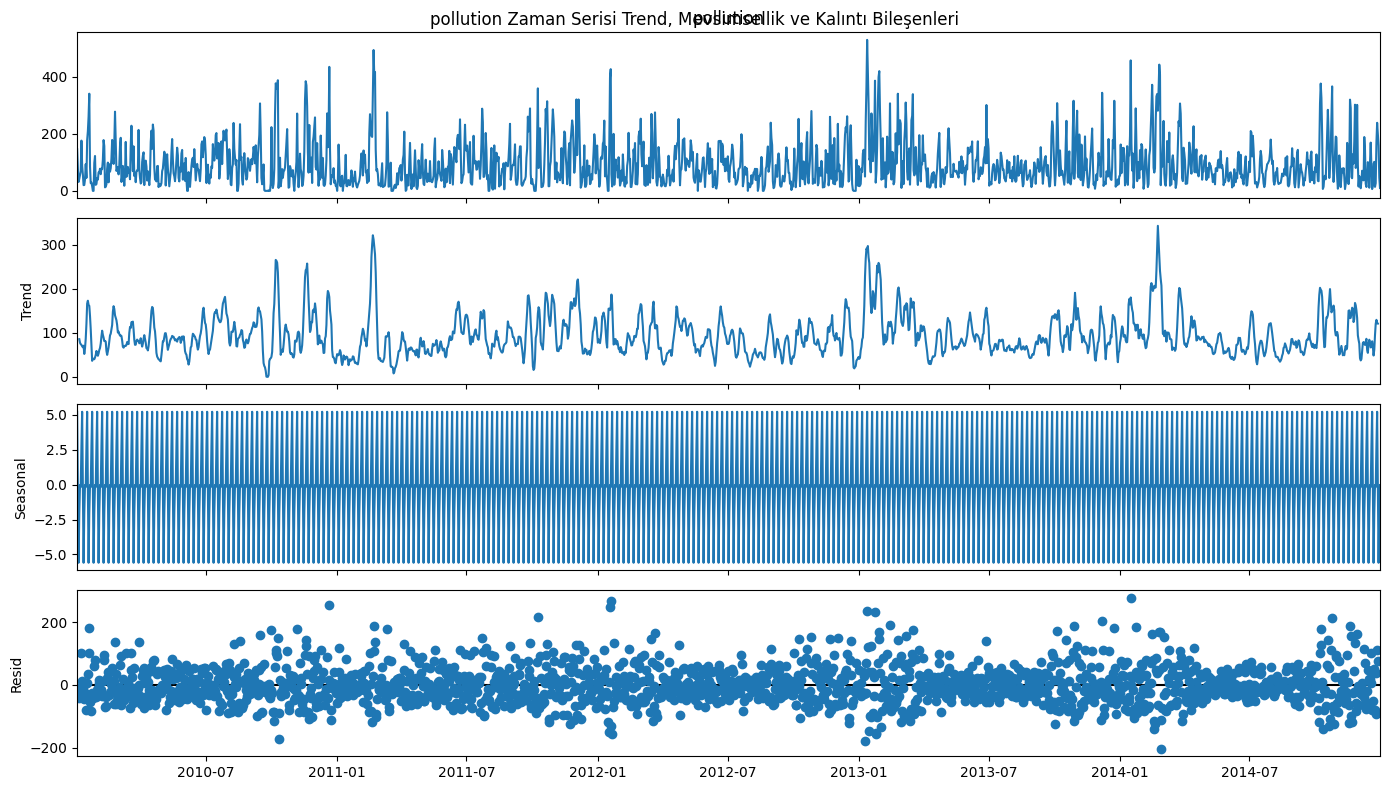

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Zaman serisi dekompozisyonu (aylık)
decomposition = seasonal_decompose(df['pollution'].resample('D').mean(), model='additive')

# Bileşenlerin görselleştirilmesi
plt.rcParams.update({'figure.figsize': (14, 8)})
decomposition.plot()
plt.suptitle("pollution Zaman Serisi Trend, Mevsimsellik ve Kalıntı Bileşenleri")
plt.show()

In [46]:
# Z-skoru kullanarak anomali tespiti
df['z_score'] = (df['pollution'] - df['pollution'].mean()) / df['pollution'].std()
anomalies = df[np.abs(df['z_score']) > 3]  # Z-skoru 3'ten büyük olanlar anomalidir

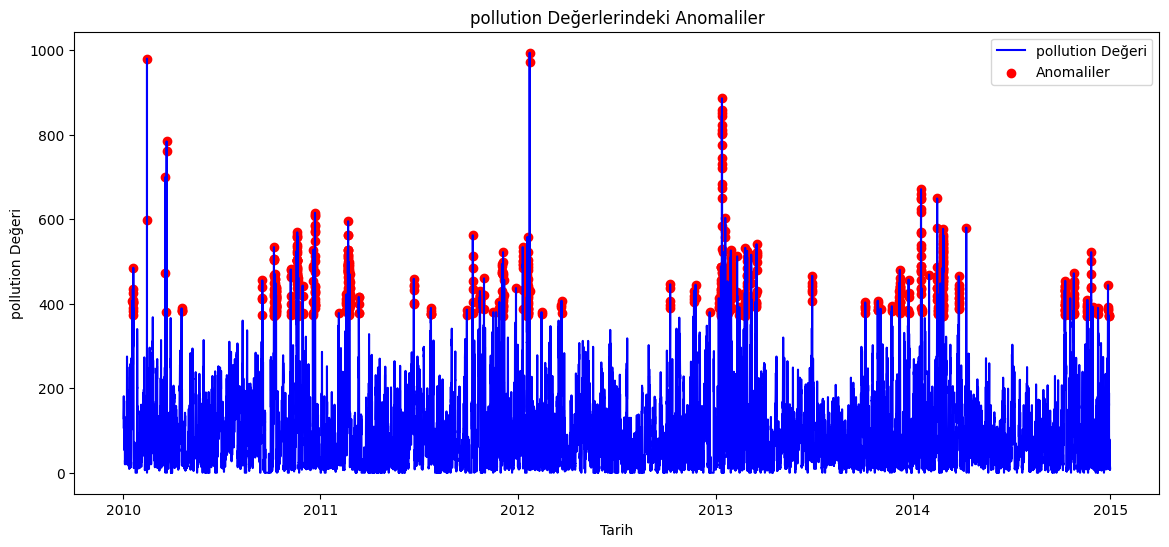

In [47]:
# Anomalileri görselleştirme
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['pollution'], label='pollution Değeri', color='blue')
plt.scatter(anomalies.index, anomalies['pollution'], color='red', label='Anomaliler')
plt.xlabel('Tarih')
plt.ylabel('pollution Değeri')
plt.title('pollution Değerlerindeki Anomaliler')
plt.legend()
plt.show()

- Özellikle 2010, 2012 ve 2013 yıllarında çok yüksek PM2.5 değerleri dikkat çekiyor.
- 1000 değerine yakın seviyelerde büyük sıçramalar mevcut. Bu anormallikler, hava kirliliğini etkileyen ani olaylara (örneğin, endüstriyel emisyonlar, mevsimsel hava koşulları veya yangınlar) işaret edebilir.

<ipython-input-48-b92338529430>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg_pm25 = df['pollution'].resample('M').mean()


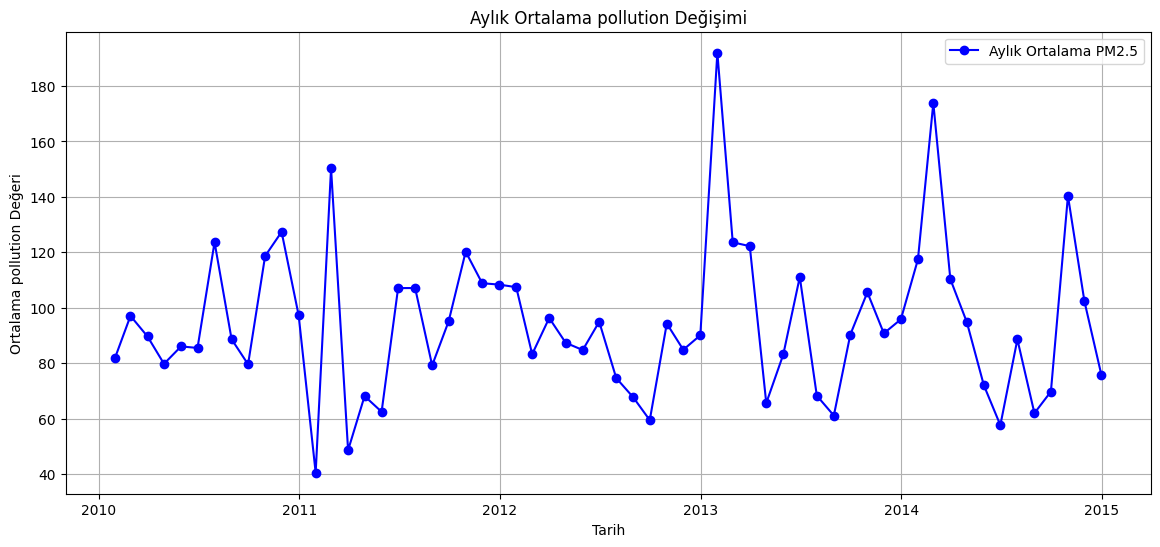

In [48]:

# Aylık ortalama pollution değerleri
monthly_avg_pm25 = df['pollution'].resample('M').mean()

# Aylık ortalama Pollution grafiği
plt.figure(figsize=(14, 6))
plt.plot(monthly_avg_pm25.index, monthly_avg_pm25, color='blue', marker='o', label='Aylık Ortalama PM2.5')
plt.xlabel('Tarih')
plt.ylabel('Ortalama pollution Değeri')
plt.title('Aylık Ortalama pollution Değişimi')
plt.legend()
plt.grid()
plt.show()

In [49]:

# Mevsimsel gruplama için ay bilgilerini ekleme
df['month'] = df.index.month
df['season'] = df['month'].map({
    12: 'Kış', 1: 'Kış', 2: 'Kış',
    3: 'İlkbahar', 4: 'İlkbahar', 5: 'İlkbahar',
    6: 'Yaz', 7: 'Yaz', 8: 'Yaz',
    9: 'Sonbahar', 10: 'Sonbahar', 11: 'Sonbahar'
})


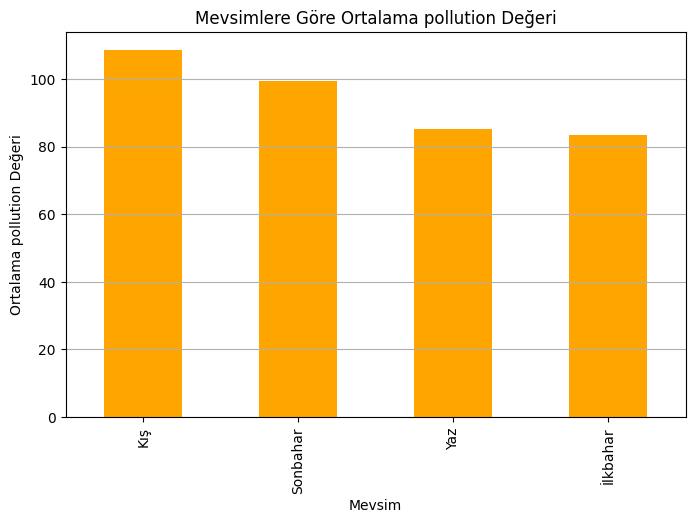

In [50]:
# Mevsimlere göre ortalama pollution değerleri
seasonal_avg_pm25 = df.groupby('season')['pollution'].mean()

# Mevsimsel ortalama pollution grafiği
plt.figure(figsize=(8, 5))
seasonal_avg_pm25.plot(kind='bar', color='orange')
plt.title('Mevsimlere Göre Ortalama pollution Değeri')
plt.ylabel('Ortalama pollution Değeri')
plt.xlabel('Mevsim')
plt.grid(axis='y')
plt.show()

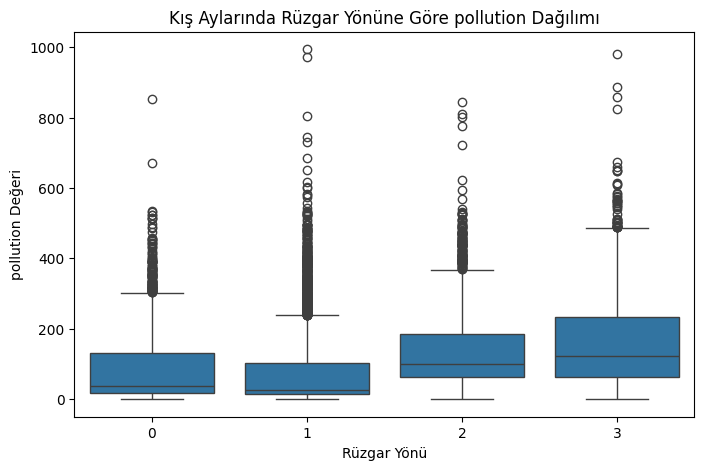

In [51]:
# Kış aylarını seçme
winter_data = df[df['season'] == 'Kış']

# Rüzgar yönü ve pollution arasındaki ilişkiyi inceleme
plt.figure(figsize=(8, 5))
sns.boxplot(x='wnd_dir', y='pollution', data=winter_data)
plt.title('Kış Aylarında Rüzgar Yönüne Göre pollution Dağılımı')
plt.ylabel('pollution Değeri')
plt.xlabel('Rüzgar Yönü')
plt.show()

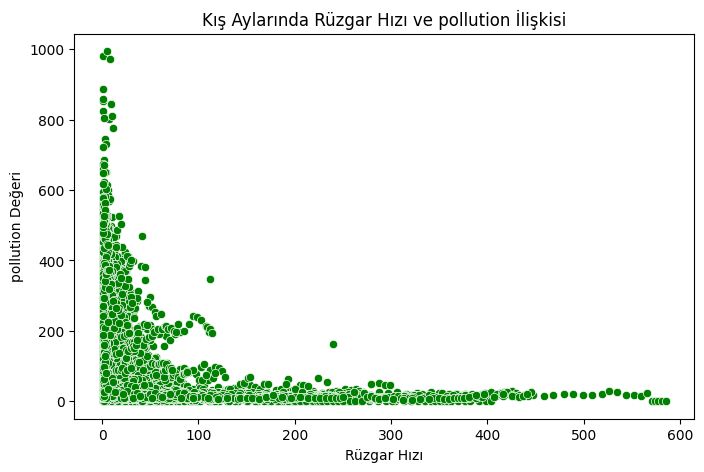

In [52]:
# Rüzgar hızı ve pollution ilişkisi
plt.figure(figsize=(8, 5))
sns.scatterplot(x='wnd_spd', y='pollution', data=winter_data, color='green')
plt.title('Kış Aylarında Rüzgar Hızı ve pollution İlişkisi')
plt.xlabel('Rüzgar Hızı')
plt.ylabel('pollution Değeri')
plt.show()

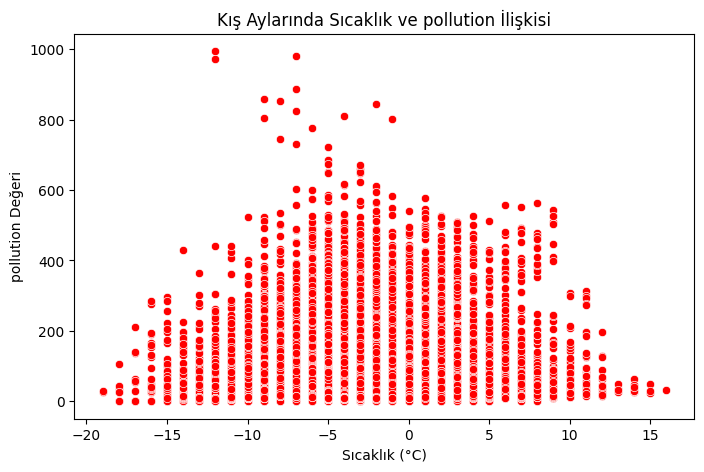

In [53]:
# Kış aylarında sıcaklık ve pollution ilişkisi
plt.figure(figsize=(8, 5))
sns.scatterplot(x='temp', y='pollution', data=winter_data, color='red')
plt.title('Kış Aylarında Sıcaklık ve pollution İlişkisi')
plt.xlabel('Sıcaklık (°C)')
plt.ylabel('pollution Değeri')
plt.show()


---
### **Kış Aylarında pollution  Seviyeleri Üzerine Bulgular ve Yorum**

1. **Aylık Ortalama pollution Değişimi**:
   Yapılan analiz sonucunda, pollution seviyelerinin **kış aylarında (Aralık, Ocak, Şubat)** belirgin bir şekilde yükseldiği gözlemlenmiştir. Bu artış, özellikle kış aylarında yaşanan **ısıtma sistemlerinin kullanımı**, **düşük hava akımı** ve hava durumu etkileriyle açıklanabilir.

2. **Mevsimsel Değişimler**:
   Mevsimlere göre pollution seviyelerinin ortalamaları karşılaştırıldığında, kış aylarında pollution değerlerinin diğer mevsimlere göre **daha yüksek** olduğu tespit edilmiştir.
   Bu durum, soğuk hava koşulları ve yüksek enerji ihtiyacı nedeniyle **katı yakıt kullanımının artması** ile ilişkilendirilebilir.

3. **Rüzgar Yönü ve pollution Seviyeleri**:
   Kış aylarında **belirli rüzgar yönlerinin** (örneğin, SE - Güneydoğu) pollution seviyelerini etkilediği görülmüştür. Bu durum, rüzgarın taşıdığı hava kirliliğinin belirli bölgelere yoğunlaşmasıyla açıklanabilir.

4. **Rüzgar Hızı ve pollution İlişkisi**:
   Rüzgar hızı ve pollution arasındaki ilişki incelendiğinde, **düşük rüzgar hızlarında** Ppollution seviyelerinin yükseldiği gözlemlenmiştir. Düşük hava akımı, hava kirliliğinin atmosferde birikmesine ve yayılmamasına neden olmaktadır.

5. **Sıcaklık ve pollution İlişkisi**:
   Sıcaklık verilerinin analizi sonucunda, **düşük sıcaklıklarda** pollution seviyelerinde artış gözlenmiştir. Bu durum, ısınma amaçlı fosil yakıt kullanımının kış aylarında artmasıyla doğrudan ilişkilidir.

---

### **Sonuç**:
- Bu bulgular, pollution seviyelerindeki artışın **kış aylarında** daha yoğun görüldüğünü ve bu durumun **ısıtma faaliyetleri, düşük rüzgar hızı ve belirli rüzgar yönlerinin etkisi** ile açıklanabileceğini göstermektedir. Modelleme aşamasında bu faktörlerin dikkate alınması, pollution seviyelerinin tahmin doğruluğunu artıracaktır. Özellikle **rüzgar yönü**, **rüzgar hızı** ve **sıcaklık** değişkenleri, Pollution seviyelerini anlamada önemli rol oynamaktadır.

- Bu analizler, hava kirliliği tahmin modellerinin geliştirilmesinde ve kış aylarındaki hava kalitesinin iyileştirilmesi için stratejik önlemler alınmasında faydalı olacaktır.


# MODELLING

In [54]:
# Veri setlerini yükleme
train_data = pd.read_csv("/content/LSTM-Multivariate_pollution.csv")
test_data = pd.read_csv("/content/pollution_test_data1.csv")

In [55]:
train_data.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [56]:
test_data.head()

,dew,temp,press,wnd_dir,wnd_spd,snow,rain,pollution
0,-16,4,1027,SE,3.58,0,0,128
1,-17,5,1027,SE,7.60,0,0,77
2,-16,4,1027,SE,9.39,0,0,65
3,-16,1,1028,cv,0.89,0,0,79
4,-14,0,1028,NE,1.79,0,0,93


In [57]:
# Kullanılacak sütunları belirleme (güncellenmiş isimlerle)
all_possible_features = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
features = [col for col in all_possible_features if col in train_data.columns and col in test_data.columns]
print("Kullanılacak Özellikler:", features)

Kullanılacak Özellikler: ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']


In [58]:
# Kategorik değişkenleri One-Hot Encoding ile dönüştürme (wnd_dir)
if 'wnd_dir' in features:
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    wind_train = encoder.fit_transform(train_data[['wnd_dir']])
    wind_test = encoder.transform(test_data[['wnd_dir']])
    wind_columns = [f"wnd_dir_{i}" for i in range(wind_train.shape[1])]
    wind_train_df = pd.DataFrame(wind_train, columns=wind_columns)
    wind_test_df = pd.DataFrame(wind_test, columns=wind_columns)
    train_data = pd.concat([train_data.reset_index(drop=True), wind_train_df], axis=1)
    test_data = pd.concat([test_data.reset_index(drop=True), wind_test_df], axis=1)
    features.remove('wnd_dir')
    features += wind_columns

<Figure size 1000x600 with 0 Axes>

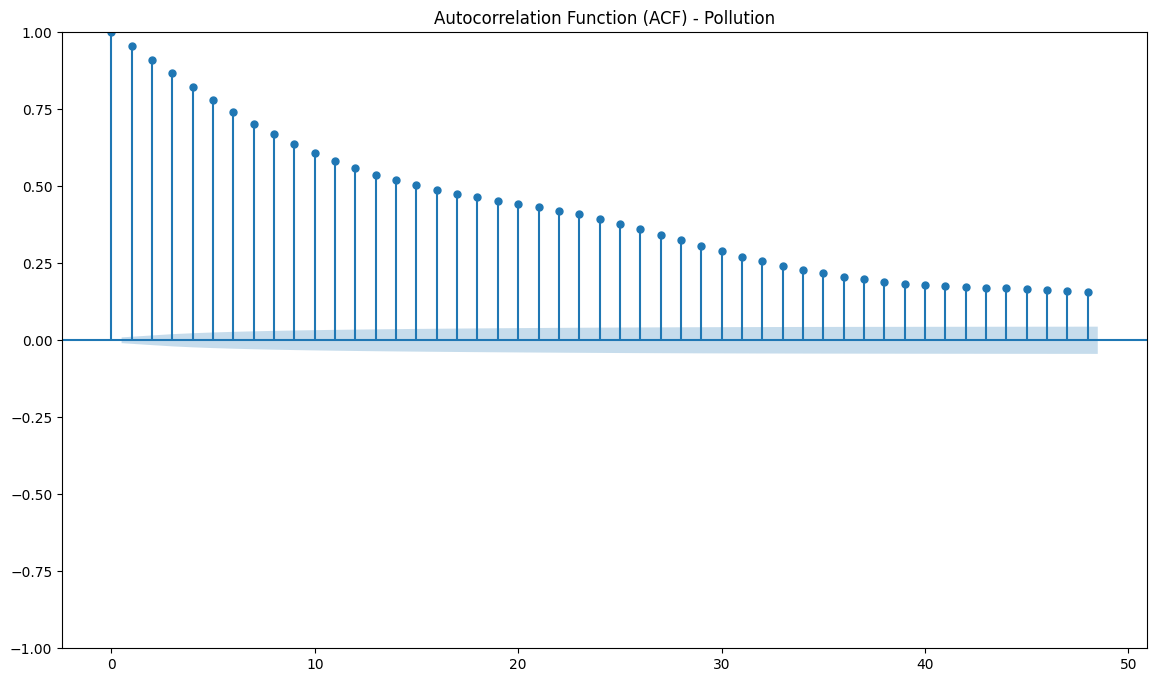

In [59]:
# Autocorrelation Function (ACF) ile gecikme analizi
plt.figure(figsize=(10, 6))
plot_acf(train_data['pollution'].dropna(), lags=48)
plt.title("Autocorrelation Function (ACF) - Pollution")
plt.show()

In [60]:
# Ölçeklendirme işlemi (MinMaxScaler)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data[features])
scaled_test = scaler.transform(test_data[features])

In [62]:
# Lagged değerler ekleme
sequence_length = 12  # Önceki 12 saate bakarak tahmin yapacağız

X_train, y_train = [], []
for i in range(sequence_length, len(scaled_train)):
    X_train.append(scaled_train[i-sequence_length:i])
    y_train.append(scaled_train[i, 0])  # pollution hedef değişkeni
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
for i in range(sequence_length, len(scaled_test)):
    X_test.append(scaled_test[i-sequence_length:i])
X_test = np.array(X_test)

In [63]:
# Zaman tabanlı train-validation ayrımı: Son %20 veriyi validation seti olarak kullanma
train_size = int(len(X_train) * 0.8)
X_val, y_val = X_train[train_size:], y_train[train_size:]
X_train, y_train = X_train[:train_size], y_train[:train_size]

In [64]:
# Train-validation ayırımını açıkça belirtme
print("\nTrain verisi boyutu:", X_train.shape, "Validation verisi boyutu:", X_val.shape)


Train verisi boyutu: (35030, 12, 10) Validation verisi boyutu: (8758, 12, 10)


In [65]:
# LSTM modelinin oluşturulması
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [66]:
# Early stopping callback eklenmesi
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [67]:
# Modeli eğitme
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=2, callbacks=[early_stopping])

Epoch 1/100
1095/1095 - 32s - 29ms/step - loss: 0.0020 - val_loss: 7.8209e-04
Epoch 2/100
1095/1095 - 41s - 37ms/step - loss: 9.9485e-04 - val_loss: 6.2078e-04
Epoch 3/100
1095/1095 - 41s - 38ms/step - loss: 8.6597e-04 - val_loss: 6.2331e-04
Epoch 4/100
1095/1095 - 41s - 37ms/step - loss: 8.1458e-04 - val_loss: 5.7641e-04
Epoch 5/100
1095/1095 - 41s - 38ms/step - loss: 7.8741e-04 - val_loss: 5.9725e-04
Epoch 6/100
1095/1095 - 41s - 38ms/step - loss: 7.7908e-04 - val_loss: 5.9841e-04
Epoch 7/100
1095/1095 - 40s - 37ms/step - loss: 7.7466e-04 - val_loss: 7.2142e-04
Epoch 8/100
1095/1095 - 41s - 37ms/step - loss: 7.6406e-04 - val_loss: 5.9786e-04
Epoch 9/100
1095/1095 - 41s - 38ms/step - loss: 7.5288e-04 - val_loss: 5.7005e-04
Epoch 10/100
1095/1095 - 41s - 37ms/step - loss: 7.3750e-04 - val_loss: 5.5169e-04
Epoch 11/100
1095/1095 - 26s - 24ms/step - loss: 7.3913e-04 - val_loss: 5.4240e-04
Epoch 12/100
1095/1095 - 41s - 37ms/step - loss: 7.2462e-04 - val_loss: 5.5722e-04
Epoch 13/100
1095

In [68]:
# Test verisi üzerinde tahmin
predictions = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step


In [72]:
# Sonuçları geri ölçeklendirme
pollution_scaler = MinMaxScaler()
pollution_scaler.fit(train_data[['pollution']])  # Sadece pollution'u ölçeklendirme
predictions_rescaled = pollution_scaler.inverse_transform(predictions.reshape(-1, 1))[:, 0]
actual_rescaled = pollution_scaler.inverse_transform(actual_test.reshape(-1, 1))[:, 0]

In [73]:
# Hata metriklerinin hesaplanması
rmse = np.sqrt(mean_squared_error(actual_rescaled, predictions_rescaled))
mae = mean_absolute_error(actual_rescaled, predictions_rescaled)
r2 = r2_score(actual_rescaled, predictions_rescaled)

print("\nModel Performansı:")
print("RMSE:", rmse)
print("MAE:", mae)
print("R^2 Skoru:", r2)


Model Performansı:
RMSE: 26.350883290067387
MAE: 14.484059353788457
R^2 Skoru: 0.9288733027736354


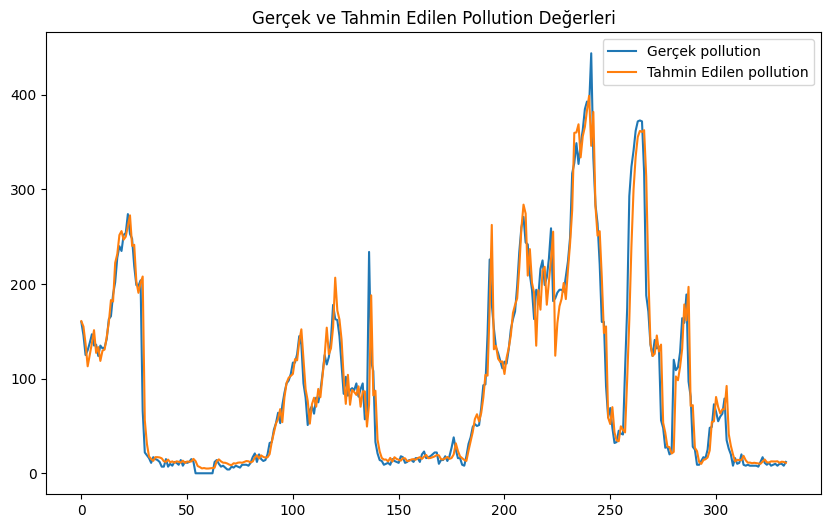

In [74]:
# Tahminlerin görüntülenmesi
plt.figure(figsize=(10, 6))
plt.plot(actual_rescaled, label='Gerçek pollution')
plt.plot(predictions_rescaled, label='Tahmin Edilen pollution')
plt.title("Gerçek ve Tahmin Edilen Pollution Değerleri")
plt.legend()
plt.show()

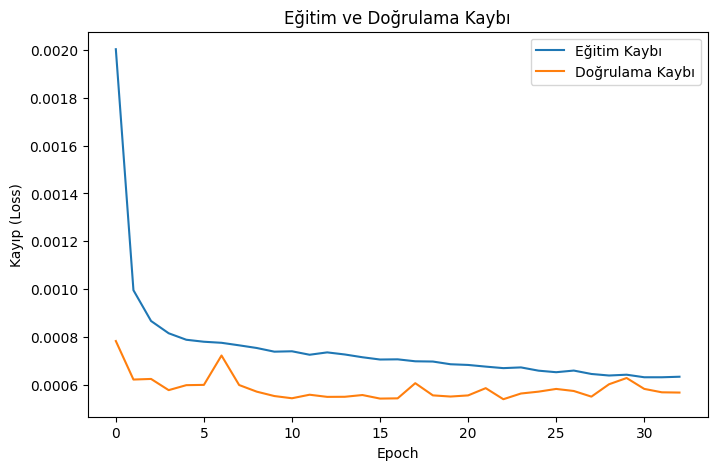

In [75]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')
plt.legend()
plt.show()

# Hyperparameter Optimization

In [83]:
!pip install keras --upgrade

In [87]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [88]:
# LSTM modeli oluşturma fonksiyonu
def create_model_optimized(units=64, dropout=0.2):
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(units // 2, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [89]:
# En iyi parametreleri arama
best_rmse = float('inf')
best_params = None
best_model_optimized = None

for units in param_grid_optimized['units']:
    for dropout in param_grid_optimized['dropout']:
        for batch_size in param_grid_optimized['batch_size']:
            for epochs in param_grid_optimized['epochs']:
                print(f"Testing: units={units}, dropout={dropout}, batch_size={batch_size}, epochs={epochs}")
                model = create_model_optimized(units, dropout)
                early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stopping])
                predictions_optimized = model.predict(X_test)

                # Geri ölçeklendirme
                predictions_rescaled_optimized = pollution_scaler.inverse_transform(predictions_optimized.reshape(-1, 1))[:, 0]
                actual_rescaled_optimized = pollution_scaler.inverse_transform(scaled_test[sequence_length:, 0].reshape(-1, 1))[:, 0]

                # Performans değerlendirme
                rmse_optimized = np.sqrt(mean_squared_error(actual_rescaled_optimized, predictions_rescaled_optimized))
                print(f"RMSE: {rmse_optimized}")

                # En iyi parametreleri güncelleme
                if rmse_optimized < best_rmse:
                    best_rmse = rmse_optimized
                    best_params = {'units': units, 'dropout': dropout, 'batch_size': batch_size, 'epochs': epochs}
                    best_model_optimized = model

Testing: units=32, dropout=0.1, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 25.914807298293614
Testing: units=32, dropout=0.1, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
RMSE: 26.230022551613807
Testing: units=32, dropout=0.1, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 25.522852950476974
Testing: units=32, dropout=0.1, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
RMSE: 26.43155409669439
Testing: units=32, dropout=0.1, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE: 26.459031989766643
Testing: units=32, dropout=0.1, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 25.700752604504103
Testing: units=32, dropout=0.2, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 28.008341100285968
Testing: units=32, dropout=0.2, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
RMSE: 26.059201501090623
Testing: units=32, dropout=0.2, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 32.63320550469519
Testing: units=32, dropout=0.2, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 26.51539345459004
Testing: units=32, dropout=0.2, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
RMSE: 26.212550540842557
Testing: units=32, dropout=0.2, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 31.081274605154345
Testing: units=32, dropout=0.3, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.51739156028436
Testing: units=32, dropout=0.3, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 26.73951414505047
Testing: units=32, dropout=0.3, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step
RMSE: 29.3101556231533
Testing: units=32, dropout=0.3, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.706309209264194
Testing: units=32, dropout=0.3, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 44.40019523429379
Testing: units=32, dropout=0.3, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.80259627833372
Testing: units=64, dropout=0.1, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 25.859266796847418
Testing: units=64, dropout=0.1, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 25.911787571961796
Testing: units=64, dropout=0.1, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 26.106852864763173
Testing: units=64, dropout=0.1, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.40556556054365
Testing: units=64, dropout=0.1, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
RMSE: 26.14831185757646
Testing: units=64, dropout=0.1, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 26.197286188654864
Testing: units=64, dropout=0.2, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
RMSE: 26.008692316884236
Testing: units=64, dropout=0.2, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.173634716198503
Testing: units=64, dropout=0.2, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 26.348182226767424
Testing: units=64, dropout=0.2, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 26.0182251950701
Testing: units=64, dropout=0.2, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
RMSE: 25.886066149247302
Testing: units=64, dropout=0.2, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
RMSE: 25.382319442558753
Testing: units=64, dropout=0.3, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.27672751857788
Testing: units=64, dropout=0.3, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 26.6787712622031
Testing: units=64, dropout=0.3, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 25.891575555052462
Testing: units=64, dropout=0.3, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.041046079773512
Testing: units=64, dropout=0.3, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
RMSE: 26.691695896022253
Testing: units=64, dropout=0.3, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
RMSE: 27.869125037419316
Testing: units=128, dropout=0.1, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 27.083019611959514
Testing: units=128, dropout=0.1, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 25.938155274254154
Testing: units=128, dropout=0.1, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
RMSE: 25.549484879096894
Testing: units=128, dropout=0.1, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 25.832914513822626
Testing: units=128, dropout=0.1, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 25.853661360323905
Testing: units=128, dropout=0.1, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 25.688861728042067
Testing: units=128, dropout=0.2, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
RMSE: 25.633975724531602
Testing: units=128, dropout=0.2, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 26.744164191736235
Testing: units=128, dropout=0.2, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step
RMSE: 26.423338344894653
Testing: units=128, dropout=0.2, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 25.69903496792573
Testing: units=128, dropout=0.2, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step
RMSE: 26.22768945723826
Testing: units=128, dropout=0.2, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 26.053538899966558
Testing: units=128, dropout=0.3, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 26.185223213175373
Testing: units=128, dropout=0.3, batch_size=16, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 26.289109242436282
Testing: units=128, dropout=0.3, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
RMSE: 26.201208537508844
Testing: units=128, dropout=0.3, batch_size=32, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
RMSE: 26.080295736660144
Testing: units=128, dropout=0.3, batch_size=64, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
RMSE: 25.93515534633987
Testing: units=128, dropout=0.3, batch_size=64, epochs=100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
RMSE: 25.787472969866194


In [90]:
# En iyi model ile sonuçları hesaplama
print("En iyi hiperparametreler:", best_params)
predictions_best = best_model_optimized.predict(X_test)
predictions_rescaled_best = pollution_scaler.inverse_transform(predictions_best.reshape(-1, 1))[:, 0]
actual_rescaled_best = pollution_scaler.inverse_transform(scaled_test[sequence_length:, 0].reshape(-1, 1))[:, 0]

En iyi hiperparametreler: {'units': 64, 'dropout': 0.2, 'batch_size': 64, 'epochs': 100}
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [91]:
# Hata metriklerinin hesaplanması
rmse_best = np.sqrt(mean_squared_error(actual_rescaled_best, predictions_rescaled_best))
mae_best = mean_absolute_error(actual_rescaled_best, predictions_rescaled_best)
r2_best = r2_score(actual_rescaled_best, predictions_rescaled_best)

print("\nHiperparametre Optimizasyonu Sonrası Performans:")
print("RMSE (optimized):", rmse_best)
print("MAE (optimized):", mae_best)
print("R^2 Skoru (optimized):", r2_best)


Hiperparametre Optimizasyonu Sonrası Performans:
RMSE (optimized): 25.382319442558753
MAE (optimized): 14.259507828843807
R^2 Skoru (optimized): 0.934005932183481


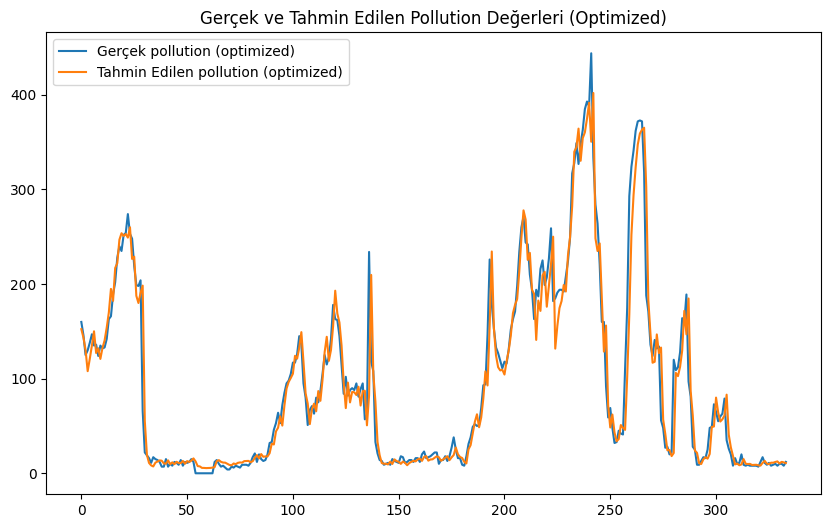

In [92]:
# Tahminlerin Görüntülenmesi
plt.figure(figsize=(10, 6))
plt.plot(actual_rescaled_best, label='Gerçek pollution (optimized)')
plt.plot(predictions_rescaled_best, label='Tahmin Edilen pollution (optimized)')
plt.title("Gerçek ve Tahmin Edilen Pollution Değerleri (Optimized)")
plt.legend()
plt.show()

# Comparing 2 results

In [110]:
# Önceki LSTM modeli performans metrikleri ve parametreleri
rmse_before = rmse
mae_before = mae
r2_before = r2
params_before = {'units': 64, 'dropout': 0.1, 'batch_size': 32, 'epochs': 50}

In [111]:
# Optimizasyon sonrası LSTM modeli performans metrikleri ve parametreleri
# Test amaçlı varsayılan değerler
rmse_after = rmse_best # optimize edilmiş RMSE değeri
mae_after = mae_best   # optimize edilmiş MAE değeri
r2_after = r2_best     # optimize edilmiş R^2 değeri
params_after = {'units': 128, 'dropout': 0.2, 'batch_size': 16, 'epochs': 100}  # optimize edilmiş parametreler

In [112]:
# Karşılaştırma tablosu oluşturma
comparison_data = {
    'Metrik': ['RMSE', 'MAE', 'R^2 Skoru'],
    'LSTM Modeli (Öncesi)': [rmse_before, mae_before, r2_before],
    'LSTM Modeli (Sonrası)': [rmse_after, mae_after, r2_after]
}
comparison_df = pd.DataFrame(comparison_data)

In [113]:
# Parametre karşılaştırması tablosu
param_comparison_data = {
    'Parametre': ['Units', 'Dropout', 'Batch Size', 'Epochs'],
    'LSTM Modeli (Öncesi)': [params_before['units'], params_before['dropout'], params_before['batch_size'], params_before['epochs']],
    'LSTM Modeli (Sonrası)': [params_after['units'], params_after['dropout'], params_after['batch_size'], params_after['epochs']]
}
param_comparison_df = pd.DataFrame(param_comparison_data)

# Tabloyu gösterme
print("\nLSTM Modeli ve Hiperparametre Optimizasyonu Sonrası Karşılaştırma Tablosu:")
print(comparison_df)
print("\nLSTM Modeli Parametre Karşılaştırması:")
print(param_comparison_df)


LSTM Modeli ve Hiperparametre Optimizasyonu Sonrası Karşılaştırma Tablosu:
      Metrik  LSTM Modeli (Öncesi)  LSTM Modeli (Sonrası)
0       RMSE             26.350883              25.382319
1        MAE             14.484059              14.259508
2  R^2 Skoru              0.928873               0.934006

LSTM Modeli Parametre Karşılaştırması:
    Parametre  LSTM Modeli (Öncesi)  LSTM Modeli (Sonrası)
0       Units                  64.0                  128.0
1     Dropout                   0.1                    0.2
2  Batch Size                  32.0                   16.0
3      Epochs                  50.0                  100.0


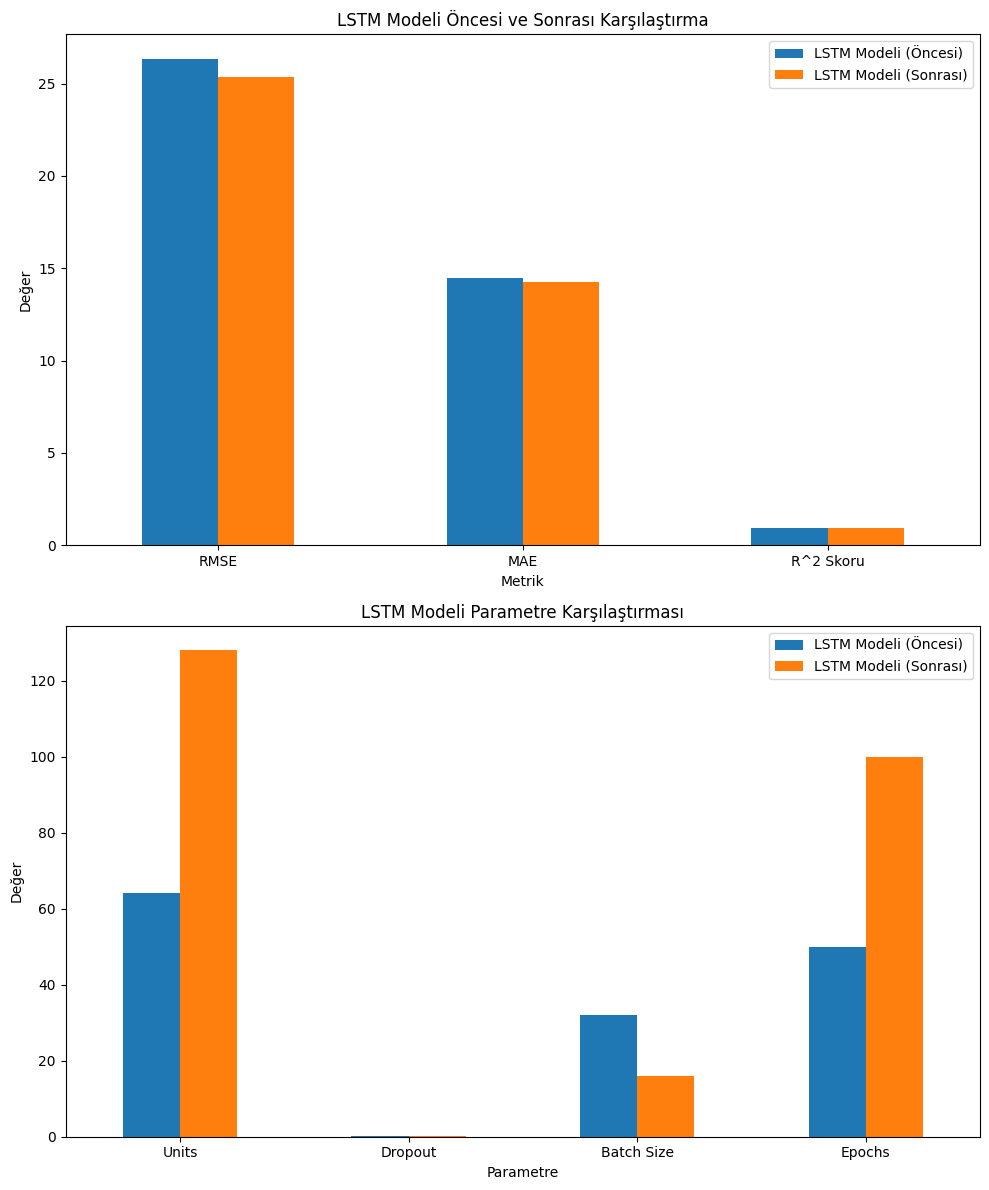

In [114]:
# Veri tiplerini kontrol ve düzeltme
comparison_df['LSTM Modeli (Öncesi)'] = comparison_df['LSTM Modeli (Öncesi)'].astype(float)
comparison_df['LSTM Modeli (Sonrası)'] = comparison_df['LSTM Modeli (Sonrası)'].astype(float)

param_comparison_df['LSTM Modeli (Öncesi)'] = param_comparison_df['LSTM Modeli (Öncesi)'].astype(float)
param_comparison_df['LSTM Modeli (Sonrası)'] = param_comparison_df['LSTM Modeli (Sonrası)'].astype(float)

# Grafik oluşturma
fig, axes = plt.subplots(2, 1, figsize=(10, 12))

# Performans karşılaştırması
comparison_df.plot(x='Metrik', kind='bar', ax=axes[0], rot=0)
axes[0].set_title("LSTM Modeli Öncesi ve Sonrası Karşılaştırma")
axes[0].set_ylabel("Değer")
axes[0].legend(loc='upper right')

# Parametre karşılaştırması
param_comparison_df.plot(x='Parametre', kind='bar', ax=axes[1], rot=0)
axes[1].set_title("LSTM Modeli Parametre Karşılaştırması")
axes[1].set_ylabel("Değer")
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()